# Bernstein-Vazirani Algorithm

1. [Bernstein-Vazirani Algorithm](#bva)
2. [Measurement Errors Mitigation](#mem)

## 1. Bernstein-Vazirani Algorithm<a id='bva'></a>

### The problem

Let the function $f$ be an oracle, which takes a string of bits as inputs and returns either $0$ or $1$:

$$ f: \{0,1\}^n \rightarrow \{ 0,1 \}$$

$f(x)$ is guaranteed to return a bitwise product of the input $x$ with a string $s$, i.e. given $x$, 
$$ f(x) = s \cdot x (\mod 2)$$

The goal of this algorithm is to **find $s$.**

### The classical solution

Classically, the most efficient method to find the secret string is by evaluating the function $n$ times with the input values $x = 2^i$ for all $i \in \{ 0 , 1 , . . . , n − 1 \}$

$$\begin{aligned}f(1000\cdots 0_{n})&=s_{1}\\f(0100\cdots 0_{n})&=s_{2}\\f(0010\cdots 0_{n})&=s_{3}\\&\,\,\,\vdots \\f(0000\cdots 1_{n})&=s_{n}\\\end{aligned}$$

In contrast to the classical solution, which needs at least $n$ queries of the function to find $s$, only one is required using quantum computing.

### The quantum solution

![BV](https://qiskit.org/textbook/ch-algorithms/images/bv1.png)

The algorithm has four main parts.

The initial state is:  $ |0\rangle ^{\otimes n+1}$

1. **Initialize the first $n$ qubits in the state $|0 \rangle$ and the last qubit in the state $|1\rangle$.** In Qiskit, all qubits are initialized in the state $|0\rangle$, so the first qubits remain unchanged. For the last qubit, we initialize it to state $|1\rangle$ by applying an $X$ gate.

$$ |0\rangle^{\otimes n} \otimes |1 \rangle$$

2. **Apply Hadamard gates to all qubits.**

Consider the first $n$ qubits: 

$$ \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1}{|x\rangle} $$

3. **Build the box containing the secret number (also known as an "oracle").** We will build it as a function that computes $s \cdot x \mod 2$  by applying $CX$ gates from the first $n$ qubits onto the last qubit whenever there is a $1$ in the secret number. We will do this in reverse order, meaning that there will be a $CX$ gate from the $n$th qubit to the last qubit if the first bit of the secret number is $1$.

The oracle applies the transformation:
$$ |x \rangle \rightarrow (-1)^{f(x)} |x\rangle$$

Therefore, the superposition transforms into:
$$ \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1}{(-1)^{f(x)}|x\rangle} $$

4. **Measure the first $n$ qubits in the Bell basis.** This means applying Hadamard gates to the first $n$ qubits again before applying measurements.

With the Hadamard: 
* For qubits where $s_i = 1$, the qubit state $| -\rangle$ converts to $|1\rangle$;
* For qubits where $s_i = 0$, the qubit state $| +\rangle$ converts to $|0\rangle$;

The algorithm may be represented by:

$ |0\rangle ^{\otimes n} \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n}{|x\rangle} \xrightarrow{U_f} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n}{(-1)^{f(x)}|x\rangle} \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^n}{(-1)^{f(x) + x \cdot y}|y\rangle} = |s\rangle  $

For a particular $y$:

$\frac{1}{2^n} \sum_{x\in \{0,1\}^n}{(-1)^{f(x) + x \cdot y}} = 
\frac{1}{2^n} \sum_{x\in \{0,1\}^n}{(-1)^{x \cdot s + x \cdot y}} = 
\frac{1}{2^n} \sum_{x\in \{0,1\}^n}{(-1)^{x \cdot ( s \otimes y)}} = 1 
\mbox{ if } s \otimes y = \overrightarrow{0}, 0 \mbox{ otherwise}$

In [125]:
# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram


Let the hidden binary string $s$ be '011':

In [126]:
s = '010'  

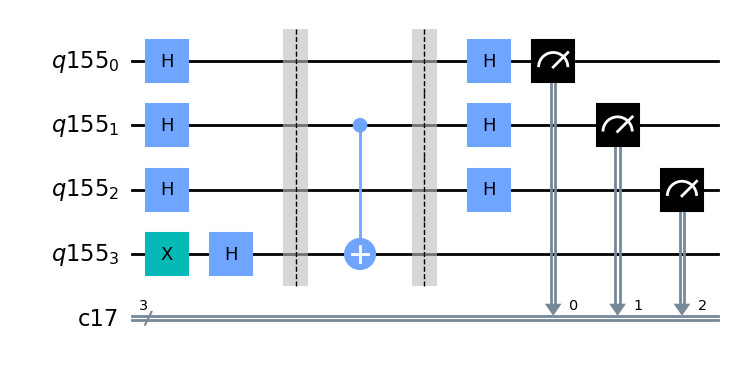

In [127]:
n = 3 # number of qubits used to represent s

# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
qr = QuantumRegister(n+1)
cr = ClassicalRegister(n)
bv_circuit = QuantumCircuit(qr, cr)

# put auxiliary in state |1>
bv_circuit.x(qr[n])

# Apply Hadamard gates to all qubits
bv_circuit.h(qr)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
# reverse s to fit qiskit's qubit ordering or explain your results
# bv_circuit.cx(qr[0], qr[n])
bv_circuit.cx(qr[1], qr[n])
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(qr[i])

# Measurement
for i in range(n):
    bv_circuit.measure(qr[i], cr[i])

bv_circuit.draw(output='mpl')


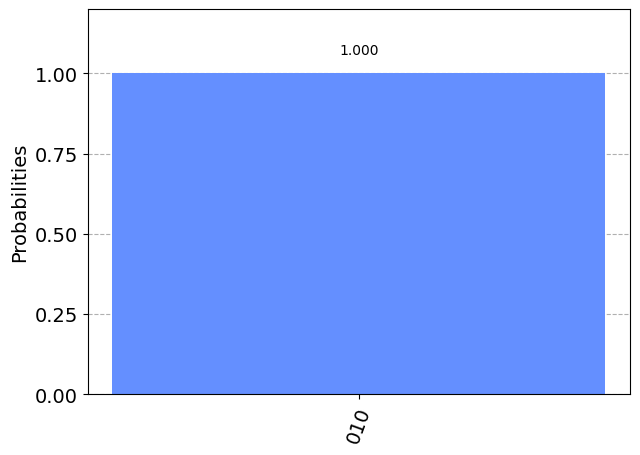

In [128]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(bv_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

<div class="alert alert-block alert-warning">
    
**Exercise**   Modify the implementation for **any string $s$**. Are the results what you expect? Explain. 
    
</div>

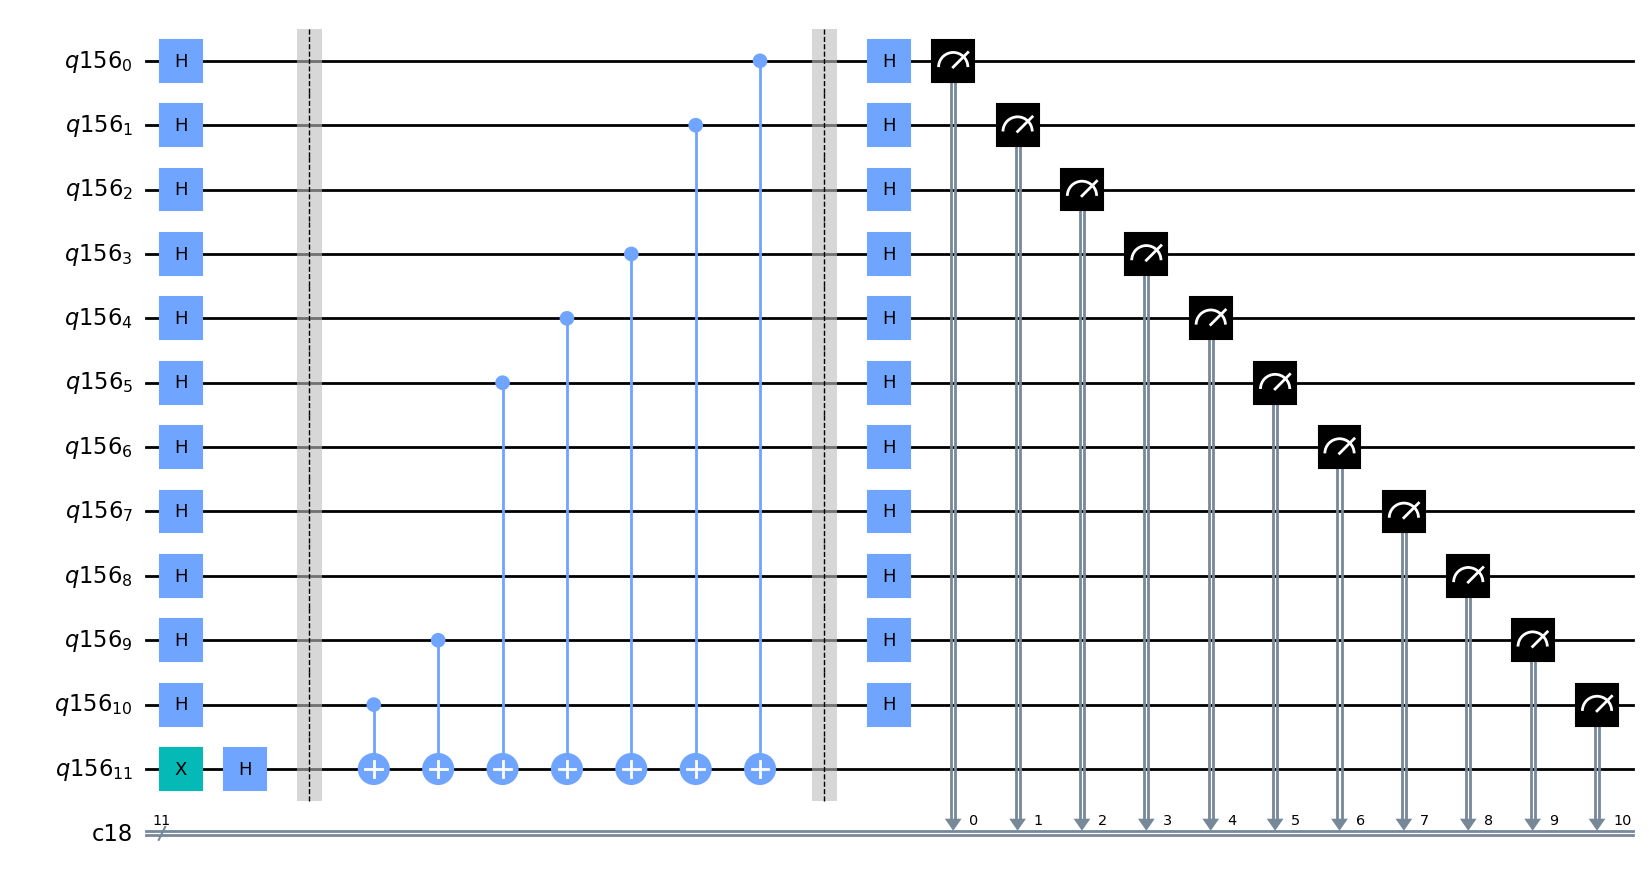

In [129]:
def Bernstein_Vazirani_circuit(string: str) -> QuantumCircuit:
    n: int = len(string)
    qr: QuantumRegister = QuantumRegister(n+1)
    cr: ClassicalRegister = ClassicalRegister(n)
    bv_circuit: QuantumCircuit = QuantumCircuit(qr, cr)

    # put auxiliary in state |1>
    bv_circuit.x(qr[n])

    # Apply Hadamard gates to all qubits
    bv_circuit.h(qr)

    # Apply barrier
    bv_circuit.barrier()

    # Apply the inner-product oracle
    for i in range(n):
        if string[i] == '1':
            bv_circuit.cx(qr[n-i-1], qr[n])

    # Apply barrier
    bv_circuit.barrier()

    # Apply Hadamard gates after querying the oracle
    for i in range(n):
        bv_circuit.h(qr[i])

    # Measurement
    for i in range(n):
        bv_circuit.measure(qr[i], cr[i])

    return bv_circuit

key: str = '11000111011'
qc = Bernstein_Vazirani_circuit(key)
qc.draw(output='mpl')

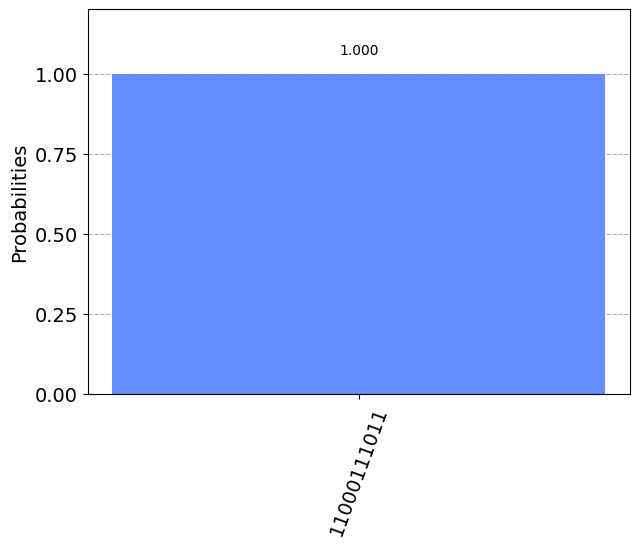

In [130]:
# simulate the circuit
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(qc)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

### References:
* [Qiskit Bernstein-Vazirani Algorithm](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html)
* [original Paper](https://epubs.siam.org/doi/10.1137/S0097539796300921)

## 2. Measurement Errors Mitigation <a id='mem'></a>

First create a **nose model**.

In [131]:
from qiskit.visualization import array_to_latex

In [132]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

# provider = IBMQ.load_account()

In [133]:
from qiskit.tools.monitor import backend_overview, backend_monitor

# backend_overview()

In [134]:
backend = provider.get_backend('ibmq_manila')
noise_model = NoiseModel.from_backend(backend)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'measure', 'sx', 'cx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [135]:
aer_sim = Aer.get_backend('aer_simulator')
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2) # 00
    if state[0]=='1': 
        qc.x(1) # 10
    if state[1]=='1':
        qc.x(0) 
    qc.measure([0, 1], [0, 1])
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc)
    counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
    print(state+' becomes', counts)

00 becomes {'11': 1, '01': 75, '10': 179, '00': 9745}
01 becomes {'11': 176, '10': 6, '00': 344, '01': 9474}
10 becomes {'01': 2, '11': 62, '00': 246, '10': 9690}
11 becomes {'01': 247, '00': 9, '10': 331, '11': 9413}


### Calibration Matrices

Generate a list of measurement calibration circuits.

Each circuit creates a basis state.

Since there we measure two qubits, we need $2^2=4$ calibration circuits.

In [136]:
from qiskit.utils.mitigation import complete_meas_cal, tensored_meas_cal, CompleteMeasFitter, TensoredMeasFitter

In [137]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1], qr=qr, circlabel='mcal')

In [138]:
state_labels

['00', '01', '10', '11']

In [139]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
         ░ ┌─┐   
q171_0: ─░─┤M├───
         ░ └╥┘┌─┐
q171_1: ─░──╫─┤M├
         ░  ║ └╥┘
 c19: 2/════╩══╩═
            0  1 

Circuit mcalcal_01
        ┌───┐ ░ ┌─┐   
q171_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
q171_1: ──────░──╫─┤M├
              ░  ║ └╥┘
 c19: 2/═════════╩══╩═
                 0  1 

Circuit mcalcal_10
              ░ ┌─┐   
q171_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
q171_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
 c19: 2/═════════╩══╩═
                 0  1 

Circuit mcalcal_11
        ┌───┐ ░ ┌─┐   
q171_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
q171_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
 c19: 2/═════════╩══╩═
                 0  1 



### Computing the calibration matrix

If there is no noise in the device, the calibration matrix would be a identity matrix $4\times4$. Since we compute this matrix with a quantum device, we expect to see noise. 

We could do this step with simulated noise from Qiskit Aer.

In [140]:
# Execute the calibration circuits without noise
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, shots=10000).result()

In [141]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0, 1], [0, 1])
qc.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

In [142]:
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, shots=10000).result()
ideal_counts = results.get_counts()
print(ideal_counts)

{'11': 4968, '00': 5032}


In [143]:
meas_fitter_id = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter_id.cal_matrix)

<IPython.core.display.Latex object>

<div class="alert alert-block alert-warning">
What is the measurement fidelity of the ideal execution?    
</div>

In [144]:
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
counts = cal_results.get_counts()
print(counts)

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)


[{'11': 4, '01': 97, '10': 157, '00': 9742}, {'10': 7, '00': 337, '11': 174, '01': 9482}, {'01': 1, '11': 77, '00': 261, '10': 9661}, {'00': 6, '10': 329, '01': 260, '11': 9405}]


<IPython.core.display.Latex object>

In [145]:
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'01': 185, '10': 287, '00': 4867, '11': 4661}



#### Fidelity results

The average assignment fidelity is the trace of the previous matrix.


In [146]:
print("Average Measurement Fidelity of ideal measurement: %f" % meas_fitter_id.readout_fidelity())

Average Measurement Fidelity of ideal measurement: 1.000000


In [147]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.957250


### Applying Calibration

We can apply a filter based on the calibration matrix to get mitigated counts.

In [148]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()
print(mitigated_counts)

{'00': 4991.292492218165, '01': 8.222054011432832, '10': 47.27290827026388, '11': 4953.21254550014}


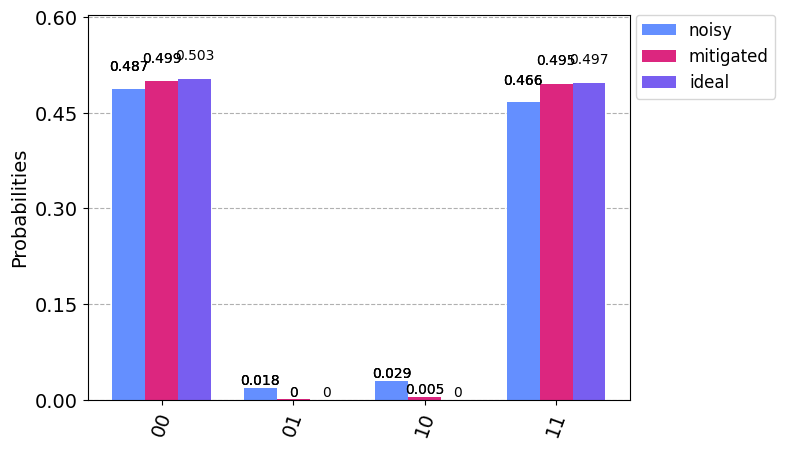

In [149]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts, ideal_counts], legend=['noisy', 'mitigated', 'ideal'])

<div class="alert alert-block alert-warning">
Comment the results.
</div>